In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from autograd import grad
import autograd.numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
class Scheduler:
    """
    Abstract class for Schedulers
    """

    def __init__(self, eta):
        self.eta = eta

    # should be overwritten
    def update_change(self, gradient):
        raise NotImplementedError

    # overwritten if needed
    def reset(self):
        pass


class Constant(Scheduler):
    def __init__(self, eta):
        super().__init__(eta)

    def update_change(self, gradient):
        return self.eta * gradient
    
    def reset(self):
        pass


class Momentum(Scheduler):
    def __init__(self, eta: float, momentum: float):
        super().__init__(eta)
        self.momentum = momentum
        self.change = 0

    def update_change(self, gradient):
        self.change = self.momentum * self.change + self.eta * gradient
        return self.change

    def reset(self):
        pass


class Adagrad(Scheduler):
    def __init__(self, eta):
        super().__init__(eta)
        self.G_t = None

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        if self.G_t is None:
            self.G_t = np.zeros((gradient.shape[0], gradient.shape[0]))

        self.G_t += gradient @ gradient.T

        G_t_inverse = 1 / (
            delta + np.sqrt(np.reshape(np.diagonal(self.G_t), (self.G_t.shape[0], 1)))
        )
        return self.eta * gradient * G_t_inverse

    def reset(self):
        self.G_t = None


class AdagradMomentum(Scheduler):
    def __init__(self, eta, momentum):
        super().__init__(eta)
        self.G_t = None
        self.momentum = momentum
        self.change = 0

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        if self.G_t is None:
            self.G_t = np.zeros((gradient.shape[0], gradient.shape[0]))

        self.G_t += gradient @ gradient.T

        G_t_inverse = 1 / (
            delta + np.sqrt(np.reshape(np.diagonal(self.G_t), (self.G_t.shape[0], 1)))
        )
        self.change = self.change * self.momentum + self.eta * gradient * G_t_inverse
        return self.change

    def reset(self):
        self.G_t = None


class RMS_prop(Scheduler):
    def __init__(self, eta, rho):
        super().__init__(eta)
        self.rho = rho
        self.second = 0.0

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero
        self.second = self.rho * self.second + (1 - self.rho) * gradient * gradient
        return self.eta * gradient / (np.sqrt(self.second + delta))

    def reset(self):
        self.second = 0.0


class Adam(Scheduler):
    def __init__(self, eta, rho, rho2):
        super().__init__(eta)
        self.rho = rho
        self.rho2 = rho2
        self.moment = 0
        self.second = 0
        self.n_epochs = 1

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        self.moment = self.rho * self.moment + (1 - self.rho) * gradient
        self.second = self.rho2 * self.second + (1 - self.rho2) * gradient * gradient

        moment_corrected = self.moment / (1 - self.rho**self.n_epochs)
        second_corrected = self.second / (1 - self.rho2**self.n_epochs)

        return self.eta * moment_corrected / (np.sqrt(second_corrected + delta))

    def reset(self):
        self.n_epochs += 1
        self.moment = 0
        self.second = 0

In [3]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [4]:
####referere til designMatrix####

def designMatrix(x, y, deg):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((deg+1)*(deg+2)/2) 
    X = np.ones((N,l))

    for i in range(1,deg+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
        
    return X[:, 1:] #removes intercept


#Scaling function for the design matrix. obtains mean= 0 and variance=1
def scale(X_train,X_test,y_train,y_test):
    x_scaler = StandardScaler(with_std=False).fit(X_train)
    X_train = x_scaler.transform(X_train)
    X_test = x_scaler.transform(X_test)
    y_scaler = StandardScaler(with_std=False).fit(y_train.reshape(-1,1))
    y_train = y_scaler.transform(y_train.reshape(-1,1)).ravel()
    y_test = y_scaler.transform(y_test.reshape(-1,1)).ravel()
    return X_train, X_test,y_train, y_test


In [33]:
 def GD_ridge(X,y,eta=1,Niterations=1000, convergence_criteria=10**(-8), lambdaa=0.001):
        np.random.seed(123)
        n_samples, n_features = X.shape
        theta = np.random.randn(n_features) # Picking out initial beta values. 
        itter = 0 #initial
        gradient_n = 0 #initial
        converge_rate = 20 #chosen initial value
        for i in range(Niterations):
            gradients = (2/n_samples) * X.T @ (X @ theta - y)+ 2*theta*lambdaa
            convergence_rate = np.linalg.norm(np.absolute(gradients-gradient_n))
            gradient_n = gradients
            theta = theta - eta*gradients
            if (converge_rate < convergence_criteria):
                itter = i
                print(f"Converged at iteration format.{i}.")
                break
        theta_gd = theta
        itter = i
        return theta_gd,itter

In [34]:
# Create data
np.random.seed(40)
n = 40     # n x n = number of datapoints
sigma2 = 0.01   # variance
sigma = np.sqrt(sigma2) #standard deviation

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)
z = FrankeFunction(x, y) + noise

X = designMatrix(x, y, 11)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2,random_state=11)
X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)

In [35]:
maxdeg = 11
degrees=np.arange(1,maxdeg+1)
Niterations = 100000 #1 000 000 is better, but takes forever
convergence = 1e-8

In [36]:
def learning_schedule(eta,decay,epoch):
    return (eta/(1+decay*epoch))

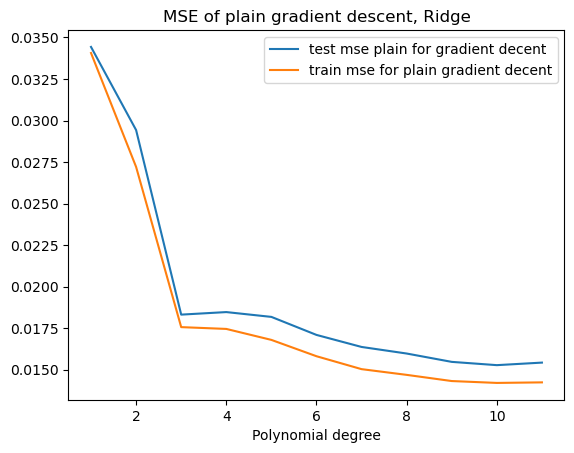

In [37]:
mse_gd_itter = []
mse_gd_poly = []
mse_gd_poly_train = []
theta = []
theta_i = 0
np.random.seed(40)
#plotting MSE against degree to check which degree we can use and to ensure the GD code is working properly. 
for i,deg in enumerate(degrees):
    X = designMatrix(x, y, deg)
    n_samples, n_features = X.shape
    z = FrankeFunction(x, y) + noise
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2,random_state=11)
    X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test) #Normalizes the data
    eta = 0.1 #uses a fixed eta 
    theta_i,itter_n = GD_ridge(X_train,z_train,eta,Niterations,convergence, lambdaa=0.000001)
    theta.append(theta_i)
    z_pred = X_test @ theta_i
    z_tilde = X_train @ theta_i
    
    mse_gd_poly.append(mean_squared_error(z_test,z_pred))
    mse_gd_poly_train.append(mean_squared_error(z_train,z_tilde))
   
plt.plot(degrees, mse_gd_poly, label='test mse plain for gradient decent')
plt.plot(degrees, mse_gd_poly_train, label='train mse for plain gradient decent')
plt.legend()
plt.xlabel("Polynomial degree")
#plt.ylabel("MSE")
plt.title("MSE of plain gradient descent, Ridge")
plt.show()
#with lambda=0.001 the OLS is better. Expected since we have no noise? takes forever to run.

#Eta=0.1, lambda=0.001 , scaling=yes, degree=8, MSE= ~ 0.021. OLS is slightly better.
#Eta=0.1, lambda=0.0001 , scaling=yes, degree=8, MSE= ~ 0.0180. OLS still slightly better.
#Eta=0.1, lambda=0.00001 , scaling=yes, degree=8, MSE= ~0.0175 . OLS is slightly better.
#Eta=0.1, lambda=0.000001 , scaling=yes, degree=8, MSE= ~ .0.0170 OLS better.

In [10]:
def minibatch_creator(X, y, batch_size):
        np.random.seed(321)
        minibatches = []
        data_matrix = np.hstack((X, y.reshape(-1, 1))) 
        np.random.shuffle(data_matrix) 
        m = data_matrix.shape[0] // batch_size 
        i=0
        for i in range(m):
            minibatch = data_matrix[i * batch_size:(i + 1)*batch_size, :]
            X_minibatch = minibatch[:, :-1] 
            Y_minibatch = minibatch[:, -1] 
            minibatches.append((X_minibatch, Y_minibatch)) 
        if data_matrix.shape[0] % batch_size != 0:
            minibatch = data_matrix[i * batch_size:data_matrix.shape[0]]
            X_minibatch = minibatch[:, :-1]
            Y_minibatch = minibatch[:, -1]
            minibatches.append((X_minibatch, Y_minibatch))
        return minibatches

In [11]:
def learning_schedule(eta,decay,epoch):
    return (eta/(1+decay*epoch))

class SGD_ridge:
    def __init__(self, eta=0.1 ,epochs=100, minibatch_size=64, schedule = str(), momentum=0.9, rho = 0.9, rho2 = 0.999 ,decay = float()):
        """
        Stochastic Gradient Descent with different optimization schedules.

        Parameters:
        - eta: Initial learning rate.
        - epochs: Number of training epochs.
        - minibatch_size: Size of minibatches used in training.
        - schedule: Optimization schedule ('Mom', 'Rms', 'Adam', 'Adagrad', 'Adagradmom', or default 'Constant').
        - momentum: Momentum parameter for 'Mom' and 'Adagradmom' schedules.
        - rho: Rho parameter for 'Rms' and 'Adam' schedules.
        - rho2: Rho2 parameter for 'Adam' schedule.
        - decay: Decay factor for the learning rate schedule.
        
        """
        self.epochs = epochs
        self.minibatch_size = minibatch_size
        self.theta = None
        self.decay = decay
        self.eta = eta
        self.learning_rate = learning_schedule(self.eta,self.decay,self.epochs)
        if schedule == 'Mom':
            self.momentum = momentum
            self.schedule = Momentum(self.learning_rate, self.momentum)
            
        elif schedule == 'Rms':
            self.rho = rho
            self.schedule = RMS_prop(self.learning_rate, self.rho)
            
        elif schedule == 'Adam':
            self.rho = rho
            self.rho2 = rho2
            self.schedule = Adam(self.learning_rate,rho,rho2)
            
        elif schedule == 'Adagrad':
            self.schedule = Adagrad(self.learning_rate)
        
        elif schedule == 'Adagradmom':
            self.momentum = momentum
            self.schedule = AdagradMomentum(self.learning_rate, self.momentum)
        
        else:
            self.schedule = Constant(self.learning_rate)      
         
            
    def fit(self, X, y, lambdaa):
        """
        Fit the model using Stochastic Gradient Descent.

        Parameters:
        - X: Input features.
        - y: Target values.
        - lambdaa: Ridge tuning parameter

        Returns:
        - Model parameters.
        - Learning rate.
        
        """
        n_samples, n_features   = X.shape
        self.theta = np.random.randn(n_features,1)
        change = np.random.randn(n_features,1)
        for epoch in range(self.epochs):
            minibatches = minibatch_creator(X,y,self.minibatch_size)
            for batch in minibatches:
                X_batch,y_batch = batch
                y_batch = y_batch.reshape(-1,1) # need a column vector
                gradients = (2/self.minibatch_size) * X_batch.T @ (X_batch @self.theta - y_batch)+2*self.theta*lambdaa
                change = self.schedule.update_change(gradients)
                self.theta = self.theta - change
                self.schedule.reset()
        lr = self.eta
        return self.theta, lr


    def predict(self, X):
        """
        Make predictions using the trained model.

        Parameters:
        - X: Input features.

        Returns:
        - Model predictions.
        """
        
        return X @ self.theta

In [12]:
gammas = np.arange(0.2,0.95,0.05)
decays = np.logspace(-6,-1,6)
n_epochs_array = np.arange(100,1000,100)
batch_size = 20
n_epochs = 1000
numberOfEtas=6
etas = np.logspace(-7,-1,numberOfEtas + 1)

In [27]:
eta_list = []
mse_eta_test = np.zeros((len(etas)))
mse_eta_train = np.zeros((len(etas)))

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

z = FrankeFunction(x, y) + noise

X = designMatrix(x, y, 8)

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2,random_state=11)
X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)

n_samples, n_features = X.shape
n_epochs_array = np.arange(10,400,1)

mse_test_01 = np.zeros(len(n_epochs_array))
mse_test_001 = np.zeros(len(n_epochs_array))
mse_test_0001 = np.zeros(len(n_epochs_array))
mse_test_00001 = np.zeros(len(n_epochs_array))

theta_j = 0
lr = 0

for i,n_epochs in enumerate(n_epochs_array+1):
    #print(i,n_epochs)
    sgd_01 = SGD_ridge(epochs = n_epochs, eta=0.1, decay=1e-4, schedule="Constant")
    theta_j, lr = sgd_01.fit(X_train, z_train, 0.00001)
    z_tilde= X_test @ theta_j
    mse_test_01[i] = mean_squared_error(z_test,z_tilde)
        
    sgd_001 = SGD_ridge(epochs = n_epochs, eta=0.01 ,decay=1e-4, schedule="Constant")
    theta_j, lr = sgd_001.fit(X_train, z_train,0.00001)
    z_tilde= X_test @ theta_j
    mse_test_001[i] = mean_squared_error(z_test,z_tilde)
        
    sgd_0001 = SGD_ridge(epochs = n_epochs, eta=0.001,decay=1e-4, schedule="Constant")
    theta_j, lr = sgd_0001.fit(X_train, z_train,0.00001)
    z_tilde= X_test @ theta_j
    mse_test_0001[i] = mean_squared_error(z_test,z_tilde)
        
    sgd_00001 = SGD_ridge(epochs = n_epochs,eta=0.0001 ,decay=1e-4, schedule="Constant")
    theta_j, lr = sgd_00001.fit(X_train, z_train,0.00001)
    z_tilde= X_test @ theta_j
    mse_test_00001[i] = mean_squared_error(z_test,z_tilde)

df_eta = pd.DataFrame(
    {'$\eta$=0.1': mse_test_01,
    '$\eta$=0.01': mse_test_001,
     '$\eta$=0.001': mse_test_0001,
     '$\eta$=0.0001': mse_test_00001})

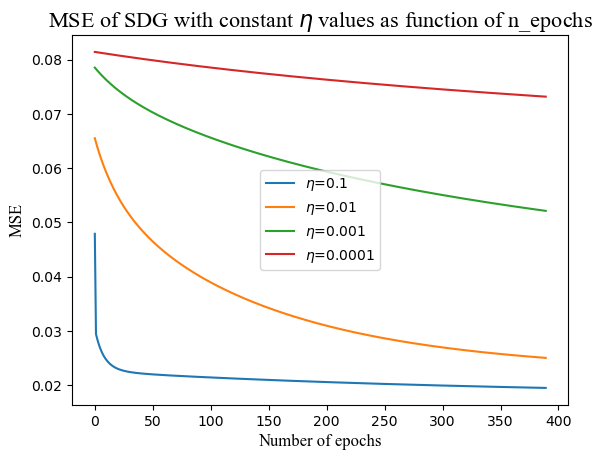

     $\eta$=0.1  $\eta$=0.01  $\eta$=0.001  $\eta$=0.0001
389    0.019505     0.025041      0.052139       0.073193


In [26]:
ax = df_eta.plot()
ax.set_title("MSE of SDG with constant $\eta$ values as function of n_epochs", fontdict={'fontfamily': 'Times new roman'}, fontsize=16)
ax.set_xlabel("Number of epochs", fontdict={'fontfamily': 'Times New Roman'}, fontsize=12)
ax.set_ylabel("MSE", fontdict={'fontfamily': 'Times New Roman'}, fontsize=12)
plt.savefig("OLS_SGD_methods.png")
plt.show()
MSE_389_epochs=df_eta[389:]
print(MSE_389_epochs)

# Comparing MSE convergence for SGD using different learning rate tuning algorithms.
Plot used in report

In [15]:
n_epochs_array = np.arange(10,400,1)
eta=0.1
mse_test_mom = np.zeros(len(n_epochs_array))
mse_test_adg = np.zeros(len(n_epochs_array))
mse_test_adgmom = np.zeros(len(n_epochs_array))
mse_test_rms = np.zeros(len(n_epochs_array))
mse_test_adam = np.zeros(len(n_epochs_array))
mse_test_const = np.zeros(len(n_epochs_array))
n_epochs_array = np.arange(10,400,1)
eta=0.1
theta_j = 0
lr = 0
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

z = FrankeFunction(x, y) + noise

X = designMatrix(x, y, 8)

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2,random_state=11)
X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)

for i,n_epochs in enumerate(n_epochs_array+1):
    sgd_const = SGD_ridge(epochs = n_epochs, minibatch_size = batch_size, decay=1e-4, schedule = 'Constant')
    theta_j, lr = sgd_const.fit(X_train, z_train, 0.00001)
    z_tilde= X_test @ theta_j
    mse_test_const[i] = mean_squared_error(z_test,z_tilde)
    
    sgd_mom = SGD_ridge(epochs = n_epochs, minibatch_size = batch_size, decay=1e-4, schedule = 'Mom')
    theta_j, lr = sgd_mom.fit(X_train, z_train, 0.00001)
    z_tilde= X_test @ theta_j
    mse_test_mom[i] = mean_squared_error(z_test,z_tilde)
        
    sgd_adg = SGD_ridge(epochs = n_epochs, minibatch_size = batch_size, decay=1e-4, schedule = 'Adagrad')
    theta_j, lr = sgd_adg.fit(X_train, z_train,0.00001)
    z_tilde= X_test @ theta_j
    mse_test_adg[i] = mean_squared_error(z_test,z_tilde)
        
    sgd_adgmom = SGD_ridge(epochs = n_epochs, minibatch_size = batch_size, decay=1e-4, schedule = 'Adagradmom')
    theta_j, lr = sgd_adgmom.fit(X_train, z_train,0.00001)
    z_tilde= X_test @ theta_j
    mse_test_adgmom[i] = mean_squared_error(z_test,z_tilde)
        
    sgd_adam = SGD_ridge(epochs = n_epochs, minibatch_size = batch_size, decay=1e-4, schedule = 'Adam')
    theta_j, lr = sgd_adam.fit(X_train, z_train,0.00001)
    z_tilde= X_test @ theta_j
    mse_test_adam[i] = mean_squared_error(z_test,z_tilde)
        
    sgd_rms = SGD_ridge(epochs = n_epochs, minibatch_size = batch_size, decay=1e-4, schedule = 'Rms')
    theta_j, lr = sgd_rms.fit(X_train, z_train, 0.00001)
    z_tilde= X_test @ theta_j
    mse_test_rms[i] = mean_squared_error(z_test,z_tilde)

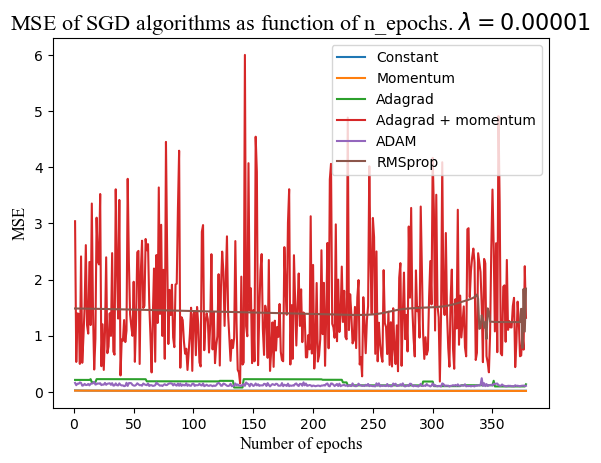

     Constant  Momentum   Adagrad  Adagrad + momentum      ADAM   RMSprop
370  0.018699  0.016248  0.096214            0.887078  0.106168  1.244928
371  0.018694  0.016246  0.096201            1.606306  0.108784  1.244639
372  0.018690  0.016243  0.096189            1.260678  0.104126  1.243975
373  0.018685  0.016241  0.096177            0.633727  0.099592  1.242515
374  0.018681  0.016239  0.096165            0.647456  0.107063  1.478490
375  0.018676  0.016237  0.096153            1.049567  0.108270  0.779972
376  0.018671  0.016235  0.096142            0.751844  0.111087  1.832461
377  0.018667  0.016233  0.096133            2.237786  0.103262  1.073812
378  0.018662  0.016231  0.134567            1.318396  0.108197  1.838184
379  0.018658  0.016228  0.125986            0.287059  0.104823  2.075188
380  0.018653  0.016226  0.125973            1.683677  0.095143  1.617592
381  0.018649  0.016224  0.125959            0.612985  0.103856  1.240894
382  0.018644  0.016222  0.125951     

In [16]:
df_algs_ridge = pd.DataFrame(
    {'Constant': mse_test_const,
     'Momentum': mse_test_mom,
     'Adagrad': mse_test_adg,
     'Adagrad + momentum': mse_test_adgmom,
     'ADAM': mse_test_adam,
     'RMSprop': mse_test_rms})

ax = df_algs_ridge[1:379].plot()
ax.set_title("MSE of SGD algorithms as function of n_epochs. $\lambda=0.00001$", fontname="Times New Roman", fontsize=16)
ax.set_xlabel("Number of epochs", fontdict={'fontfamily': 'Times New Roman'}, fontsize=12)
ax.set_ylabel("MSE", fontdict={'fontfamily': 'Times New Roman'}, fontsize=12)
plt.savefig("OLS_SDG_eta_n_epochs_scaled_eta0.1_ridge.png")
plt.show()

#to extract MSE values at exactly 50 and 290 epochs. 
print(df_algs_ridge[370:])
print(df_algs_ridge[45:55])

With Ridge regression and lambda_2=0.00001, RMSprop performs best with 290 epochs.
With only 50 epochs, RMSprop, ADAM and Adagrad performs (approximately) equally well. 


NB! something happened to this code last minute, I don't know why. Results from a previous run is presented in the project. 

In [17]:
n_epochs_array = np.arange(100,1000,100) #increase step size to reduce running time
batch_sizes = np.array([10,20,50,100,200,500,len(X_train)])
theta_j = 0
lr = 0

mse_test_const = np.zeros((len(batch_sizes),len(n_epochs_array)))
mse_test_mom = np.zeros((len(batch_sizes),len(n_epochs_array)))
mse_test_adg = np.zeros((len(batch_sizes),len(n_epochs_array)))
mse_test_adgmom = np.zeros((len(batch_sizes),len(n_epochs_array)))
mse_test_rms = np.zeros((len(batch_sizes),len(n_epochs_array)))
mse_test_adam = np.zeros((len(batch_sizes),len(n_epochs_array)))


for i,batch_size in enumerate(batch_sizes):
    for j,n_epochs in enumerate(n_epochs_array):
        sgd_const = SGD_ridge(epochs = n_epochs, minibatch_size = batch_size, momentum = 0.9, decay=1e-4, schedule = 'Constant')
        theta_j, lr = sgd_const.fit(X_train, z_train, lambdaa=0.00001)
        z_tilde= X_test @ theta_j
        mse_test_const[i,j] = mean_squared_error(z_test,z_tilde)
        
        sgd_mom = SGD_ridge(epochs = n_epochs, minibatch_size = batch_size, momentum = 0.9,  decay=1e-4, schedule = 'Mom')
        theta_j, lr = sgd_mom.fit(X_train, z_train, lambdaa=0.00001)
        z_tilde= X_test @ theta_j
        mse_test_mom[i,j] = mean_squared_error(z_test,z_tilde)
        
        sgd_adg = SGD_ridge(epochs = n_epochs, minibatch_size = batch_size, momentum = 0.9, decay=1e-4, schedule = 'Adagrad')
        theta_j, lr = sgd_adg.fit(X_train, z_train, lambdaa=0.00001)
        z_tilde= X_test @ theta_j
        mse_test_adg[i,j] = mean_squared_error(z_test,z_tilde)
        
        sgd_adgmom = SGD_ridge(epochs = n_epochs, minibatch_size = batch_size, momentum = 0.9, decay=1e-4, schedule = 'Adagradmom')
        theta_j, lr = sgd_adgmom.fit(X_train, z_train, lambdaa=0.00001)
        z_tilde= X_test @ theta_j
        mse_test_adgmom[i,j] = mean_squared_error(z_test,z_tilde)
        
        sgd_adam = SGD_ridge(epochs = n_epochs, minibatch_size = batch_size, momentum = 0.9, decay=1e-4, schedule = 'Adam')
        theta_j, lr = sgd_adam.fit(X_train, z_train, lambdaa=0.00001)
        z_tilde= X_test @ theta_j
        mse_test_adam[i,j] = mean_squared_error(z_test,z_tilde)
        
        sgd_rms = SGD_ridge(epochs = n_epochs, minibatch_size = batch_size, momentum = 0.9, decay=1e-4, schedule = 'Rms')
        theta_j, lr = sgd_rms.fit(X_train, z_train, lambdaa=0.00001)
        z_tilde= X_test @ theta_j
        mse_test_rms[i,j] = mean_squared_error(z_test,z_tilde)
        
formatted_batch_sizes = ["{:.2g}".format(i) for i in batch_sizes]

df_const = pd.DataFrame(mse_test_const, index = formatted_batch_sizes, columns = n_epochs_array)
df_mom = pd.DataFrame(mse_test_mom, index = formatted_batch_sizes, columns = n_epochs_array)
df_adg = pd.DataFrame(mse_test_adg, index = formatted_batch_sizes, columns = n_epochs_array)
df_adgmom = pd.DataFrame(mse_test_adgmom, index = formatted_batch_sizes, columns = n_epochs_array)
df_adam = pd.DataFrame(mse_test_adam, index = formatted_batch_sizes, columns = n_epochs_array)
df_rms = pd.DataFrame(mse_test_rms, index = formatted_batch_sizes, columns = n_epochs_array)

Text(0.5, 1.0, 'RMSprop: MSE epochs VS batch_size')

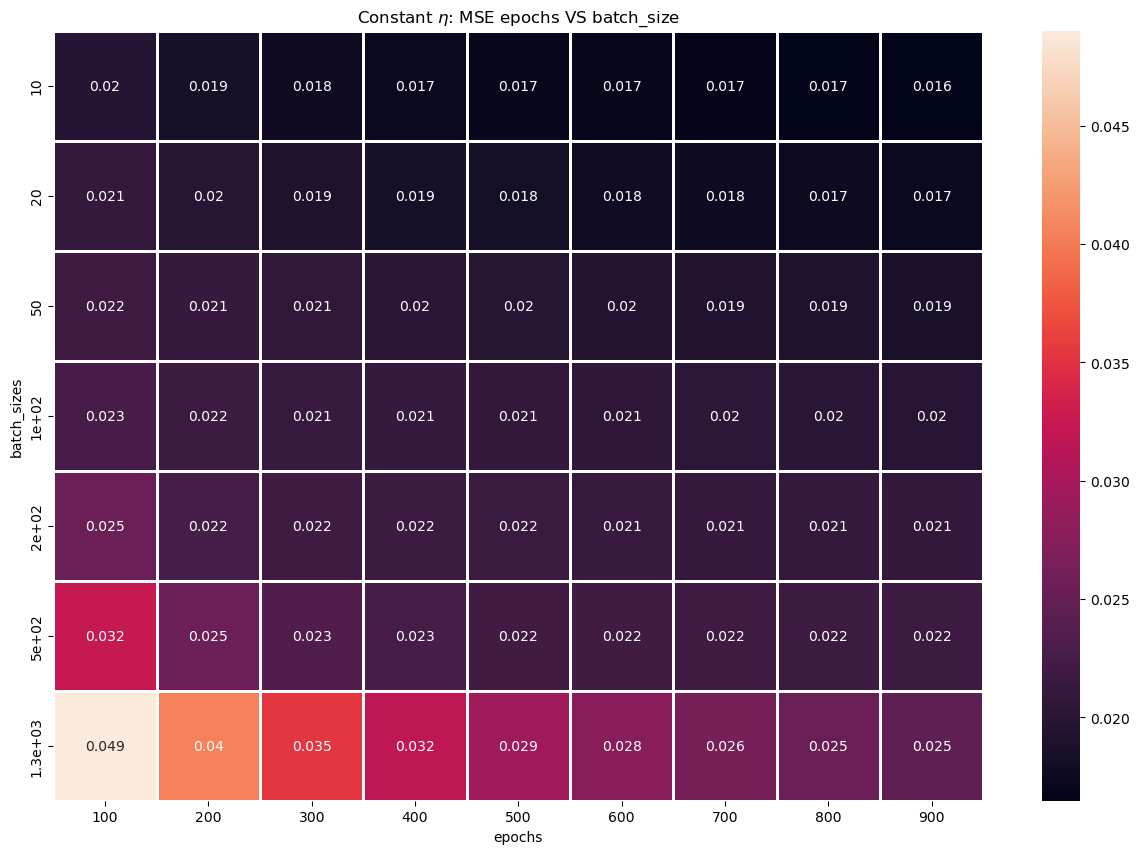

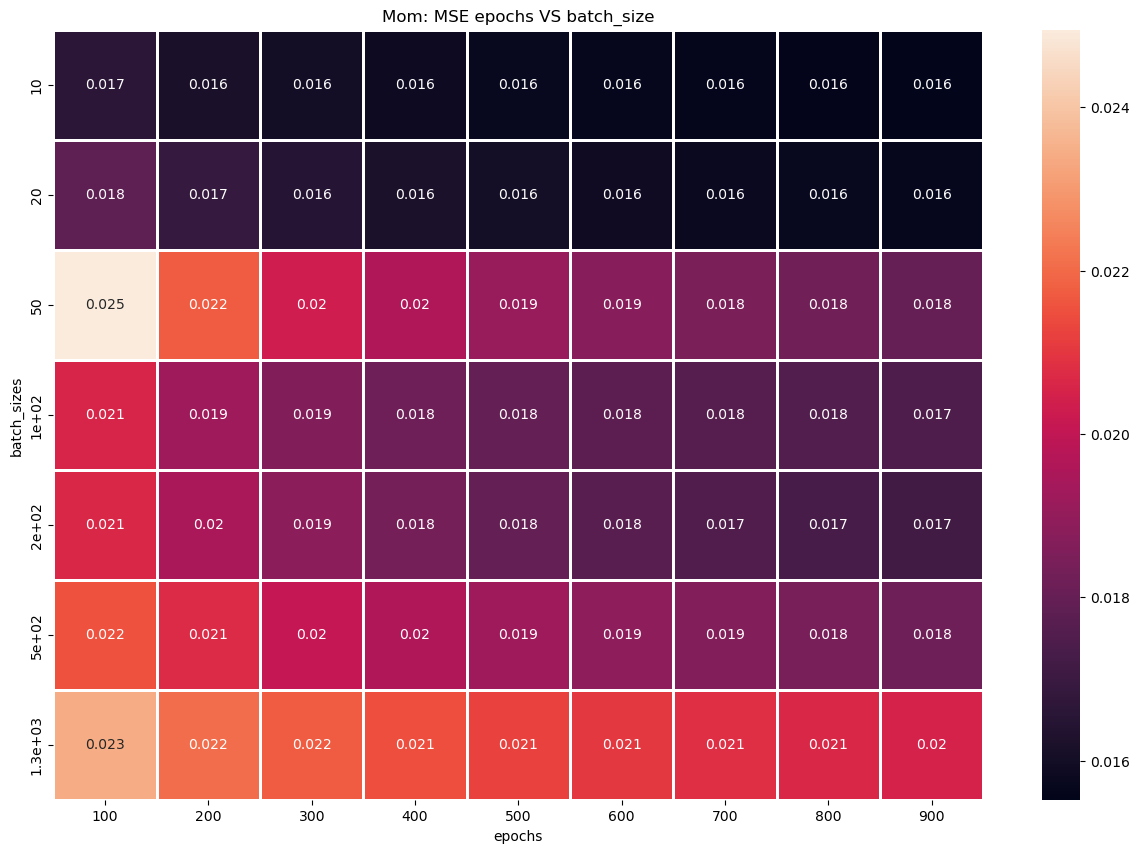

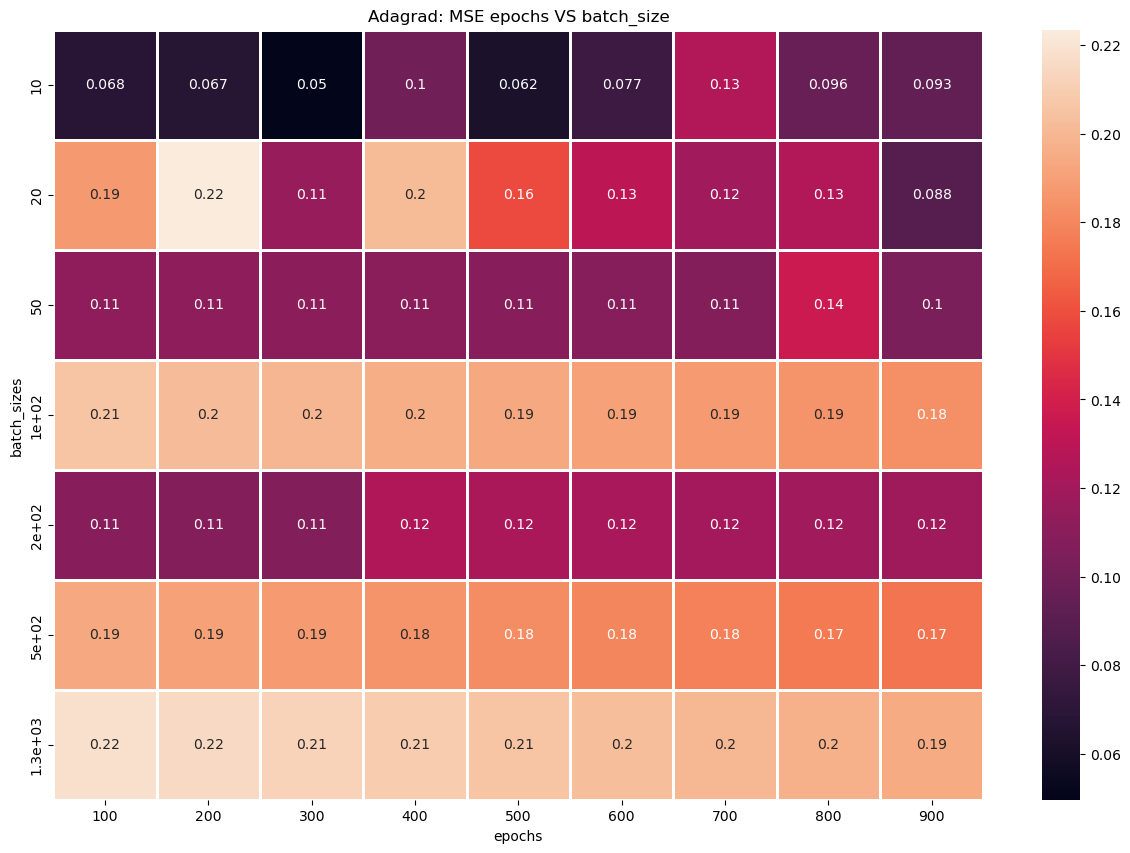

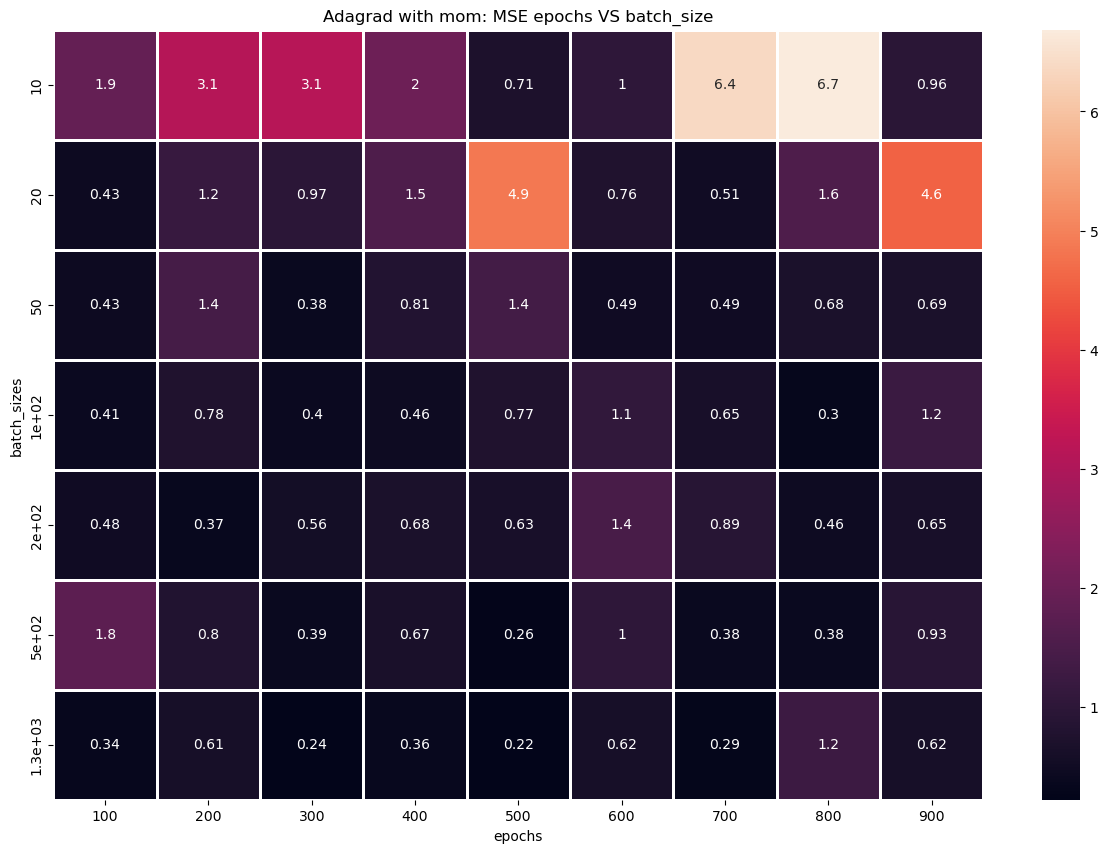

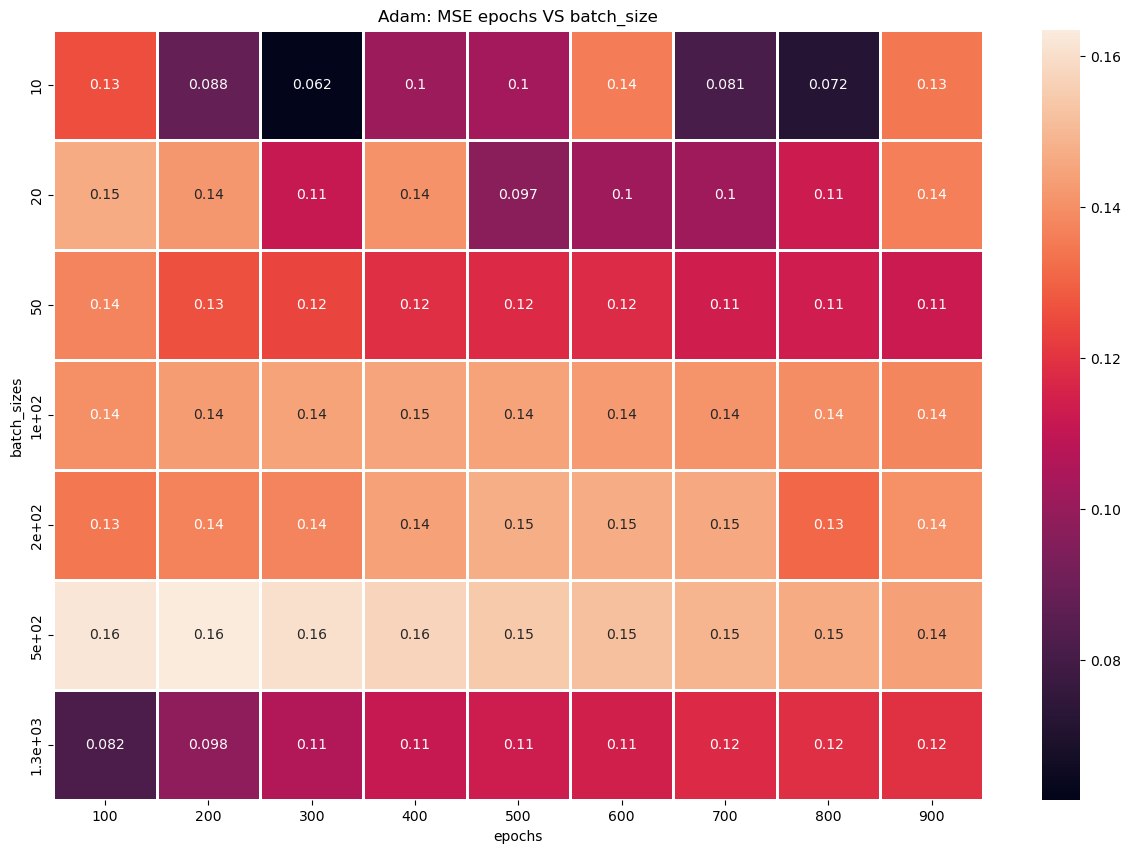

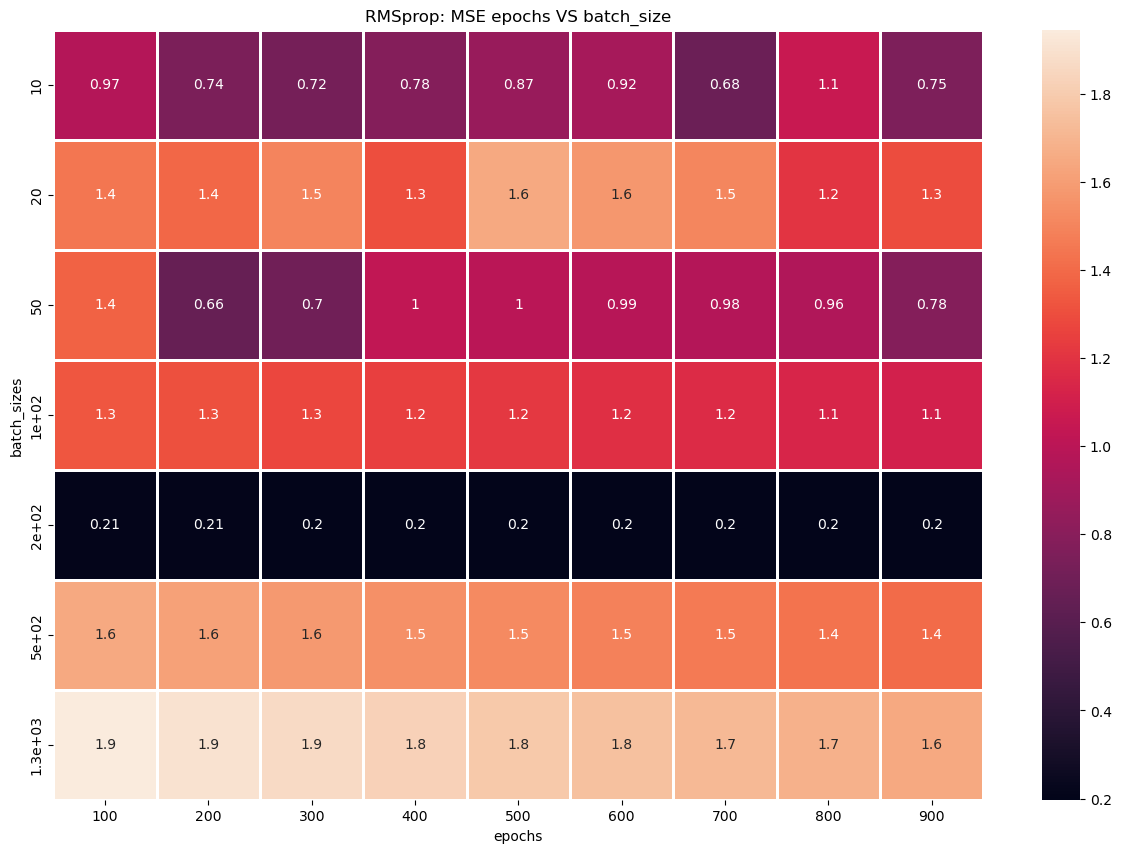

In [18]:
fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_const,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('Constant $\eta $: MSE epochs VS batch_size')

fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_mom,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('Mom: MSE epochs VS batch_size')

fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_adg,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('Adagrad: MSE epochs VS batch_size')

fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_adgmom,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('Adagrad with mom: MSE epochs VS batch_size')

fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_adam,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('Adam: MSE epochs VS batch_size')

fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_rms,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('RMSprop: MSE epochs VS batch_size')

Results are suddenly super high. Check the OLS one, the results make much more sense with $\eta=0.01$.

With only a single batch/batch size of 1600, the MSE is the same as for GD.

In [19]:
numberOfEtas=6
numberOfLambdas=6
etas = np.logspace(-7,-1,numberOfEtas + 1)
lambdas = np.logspace(-6,0, numberOfLambdas+1)
lambda_list=[]
eta_list = []
mse_eta_test = np.zeros((len(lambdas),len(etas)))
mse_eta_train = np.zeros((len(lambdas),len(etas)))

X = designMatrix(x, y, 8)
z = FrankeFunction(x, y) + noise
n_samples, n_features = X.shape
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2,random_state=11)
X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)

itteration_list = np.zeros((len(lambdas),len(etas)))
for i, lmb in enumerate(lambdas):
    #print(i, lmb)
    lambda_list.append(lmb)
    for j,eta in enumerate(etas):
        #print(j, etas)
        sgd_const = SGD_ridge(eta, decay=1e-4, epochs=300, schedule= "Mom")
        theta_i,itter_j = sgd_const.fit(X_train, z_train,lmb)     
        z_pred_ridge = X_train @ theta_i
        z_tilde_ridge = X_test@ theta_i
        itteration_list[i,j] = itter_j
        mse_eta_test[i,j] = mean_squared_error(z_train,z_pred_ridge)
        mse_eta_train[i,j] = mean_squared_error(z_test,z_tilde_ridge)

df_const = pd.DataFrame(mse_eta_test, index = lambda_list, columns = etas)

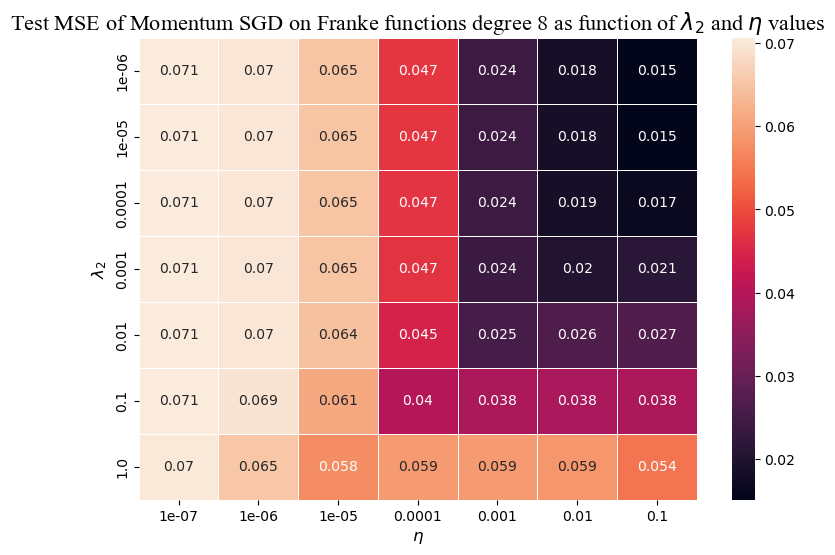

In [20]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df_const, annot=True, fmt=".2g", linewidths=.5, ax=ax)
ax.set_ylabel('$\lambda_2$', fontdict={'fontfamily': 'Times New Roman'}, fontsize=12)
ax.set_xlabel('$\eta$', fontdict={'fontfamily': 'Times New Roman'}, fontsize=12)
plt.title("Test MSE of Momentum SGD on Franke functions degree 8 as function of $\lambda_2$ and $\eta$ values",fontdict={'fontfamily': 'Times New Roman'}, fontsize=16)
plt.savefig("MSE_ETAS_LAMBDAS_momentum")
plt.show()

## Tries with a smaller $\eta$ of 0.01

In [21]:
n_epochs_array = np.arange(100,1000,100) #increase step size to reduce running time
batch_sizes = np.array([10,20,50,100,200,500,len(X_train)])
theta_j = 0
lr = 0

mse_test_const = np.zeros((len(batch_sizes),len(n_epochs_array)))
mse_test_mom = np.zeros((len(batch_sizes),len(n_epochs_array)))
mse_test_adg = np.zeros((len(batch_sizes),len(n_epochs_array)))
mse_test_adgmom = np.zeros((len(batch_sizes),len(n_epochs_array)))
mse_test_rms = np.zeros((len(batch_sizes),len(n_epochs_array)))
mse_test_adam = np.zeros((len(batch_sizes),len(n_epochs_array)))


for i,batch_size in enumerate(batch_sizes):
    for j,n_epochs in enumerate(n_epochs_array):
        sgd_const = SGD_ridge(epochs = n_epochs, minibatch_size = batch_size, eta=0.01, momentum = 0.9, decay=1e-4, schedule = 'Constant')
        theta_j, lr = sgd_const.fit(X_train, z_train, lambdaa=0.00001)
        z_tilde= X_test @ theta_j
        mse_test_const[i,j] = mean_squared_error(z_test,z_tilde)
        
        sgd_mom = SGD_ridge(epochs = n_epochs, minibatch_size = batch_size,eta=0.01, momentum = 0.9,  decay=1e-4, schedule = 'Mom')
        theta_j, lr = sgd_mom.fit(X_train, z_train, lambdaa=0.00001)
        z_tilde= X_test @ theta_j
        mse_test_mom[i,j] = mean_squared_error(z_test,z_tilde)
        
        sgd_adg = SGD_ridge(epochs = n_epochs, minibatch_size = batch_size,eta=0.01 ,momentum = 0.9, decay=1e-4, schedule = 'Adagrad')
        theta_j, lr = sgd_adg.fit(X_train, z_train, lambdaa=0.00001)
        z_tilde= X_test @ theta_j
        mse_test_adg[i,j] = mean_squared_error(z_test,z_tilde)
        
        sgd_adgmom = SGD_ridge(epochs = n_epochs, minibatch_size = batch_size, eta=0.01 ,  momentum = 0.9, decay=1e-4, schedule = 'Adagradmom')
        theta_j, lr = sgd_adgmom.fit(X_train, z_train, lambdaa=0.00001)
        z_tilde= X_test @ theta_j
        mse_test_adgmom[i,j] = mean_squared_error(z_test,z_tilde)
        
        sgd_adam = SGD_ridge(epochs = n_epochs, minibatch_size = batch_size, eta=0.01, momentum = 0.9, decay=1e-4, schedule = 'Adam')
        theta_j, lr = sgd_adam.fit(X_train, z_train, lambdaa=0.00001)
        z_tilde= X_test @ theta_j
        mse_test_adam[i,j] = mean_squared_error(z_test,z_tilde)
        
        sgd_rms = SGD_ridge(epochs = n_epochs, minibatch_size = batch_size,eta=0.01 ,momentum = 0.9, decay=1e-4, schedule = 'Rms')
        theta_j, lr = sgd_rms.fit(X_train, z_train, lambdaa=0.00001)
        z_tilde= X_test @ theta_j
        mse_test_rms[i,j] = mean_squared_error(z_test,z_tilde)
        
formatted_batch_sizes = ["{:.2g}".format(i) for i in batch_sizes]

df_const = pd.DataFrame(mse_test_const, index = formatted_batch_sizes, columns = n_epochs_array)
df_mom = pd.DataFrame(mse_test_mom, index = formatted_batch_sizes, columns = n_epochs_array)
df_adg = pd.DataFrame(mse_test_adg, index = formatted_batch_sizes, columns = n_epochs_array)
df_adgmom = pd.DataFrame(mse_test_adgmom, index = formatted_batch_sizes, columns = n_epochs_array)
df_adam = pd.DataFrame(mse_test_adam, index = formatted_batch_sizes, columns = n_epochs_array)
df_rms = pd.DataFrame(mse_test_rms, index = formatted_batch_sizes, columns = n_epochs_array)

Text(0.5, 1.0, 'RMSprop: MSE epochs VS batch_size')

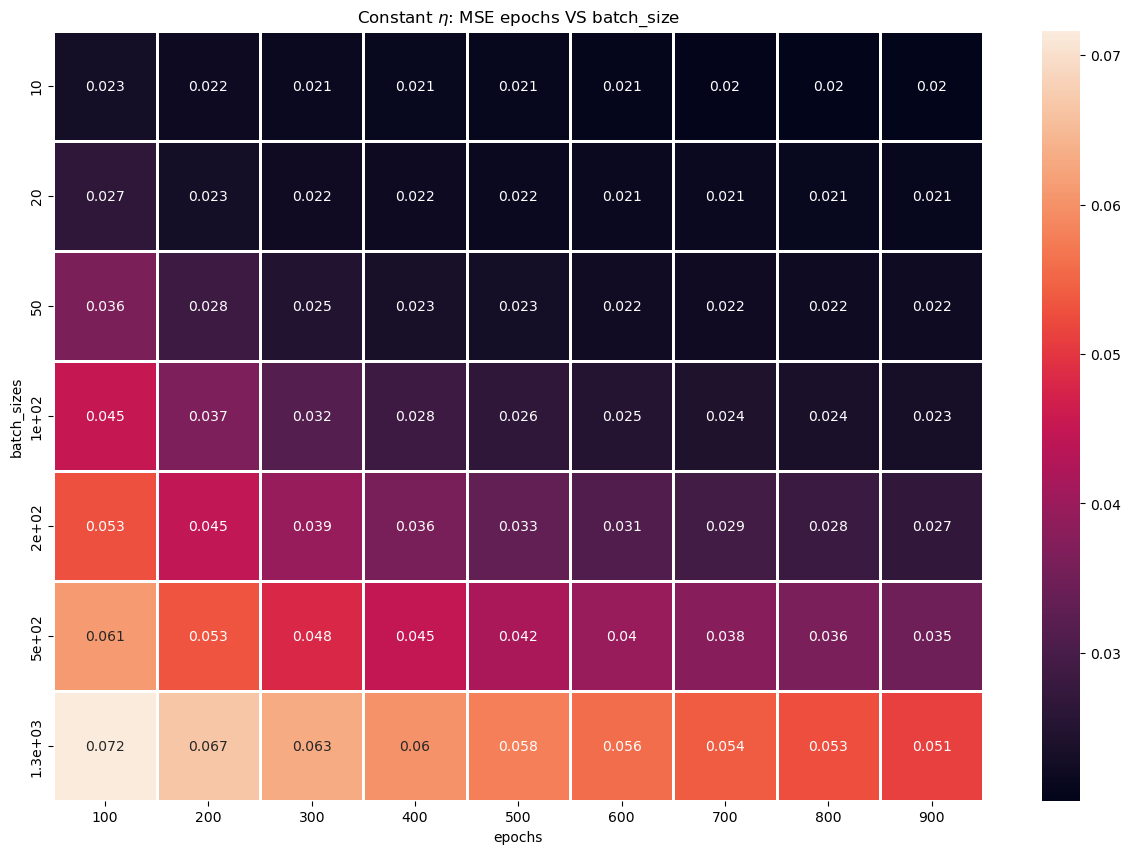

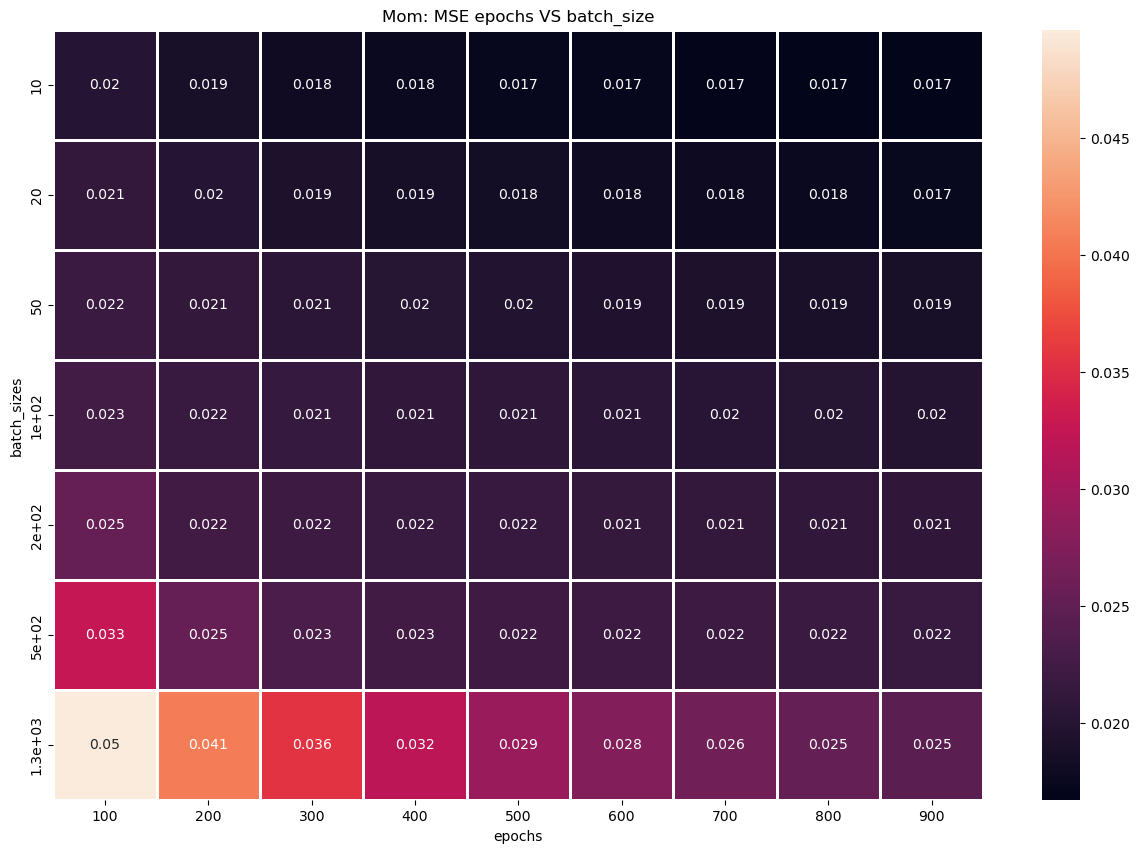

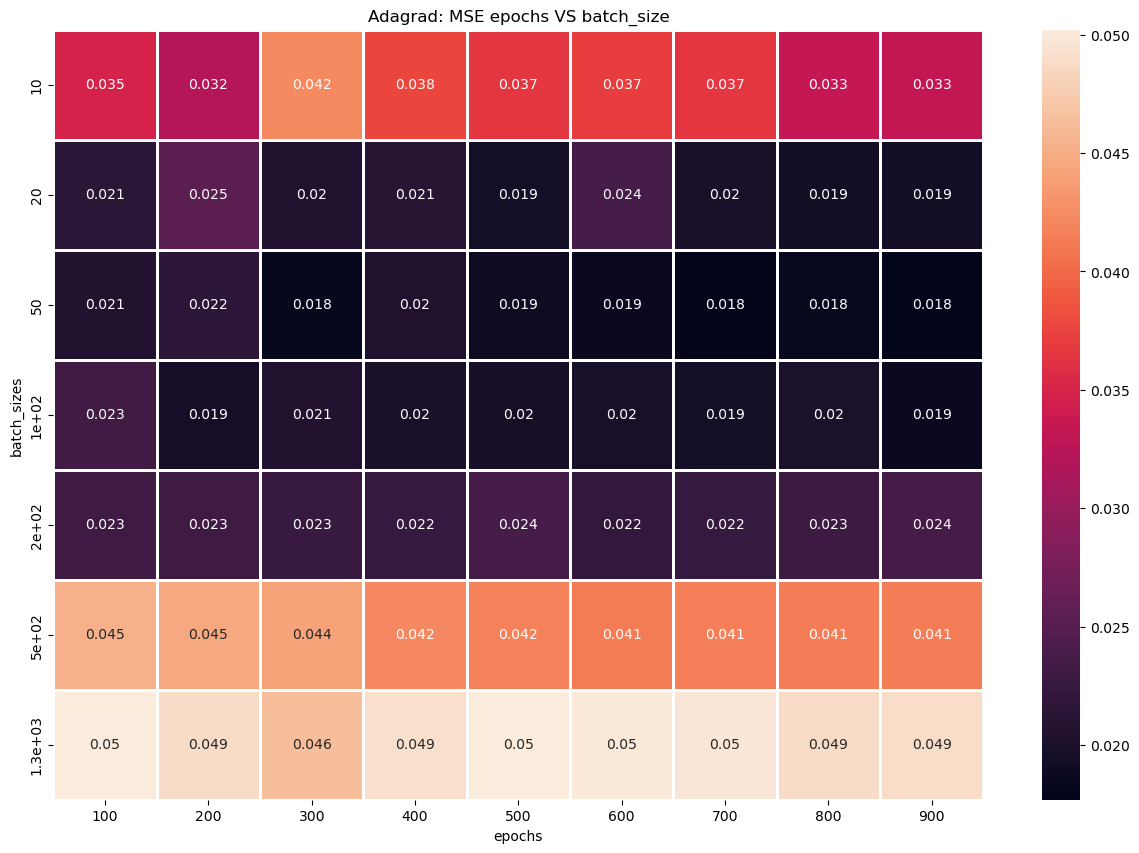

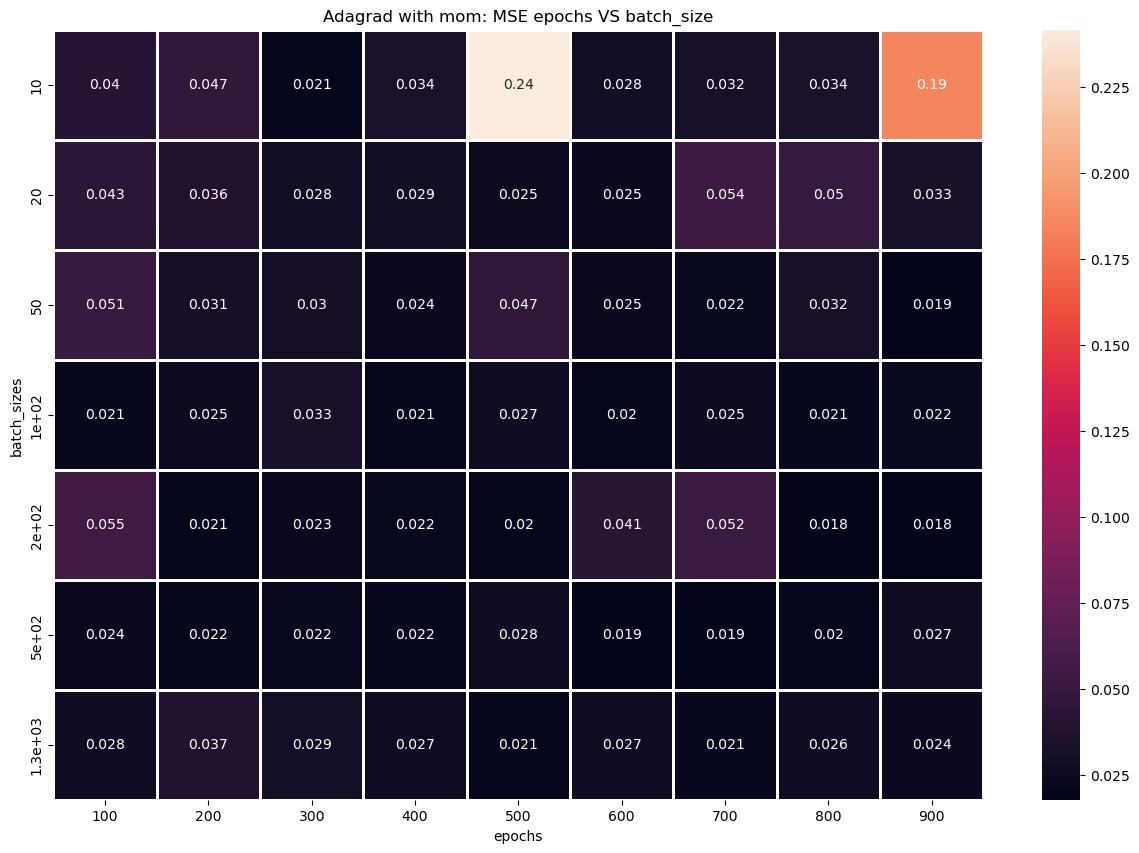

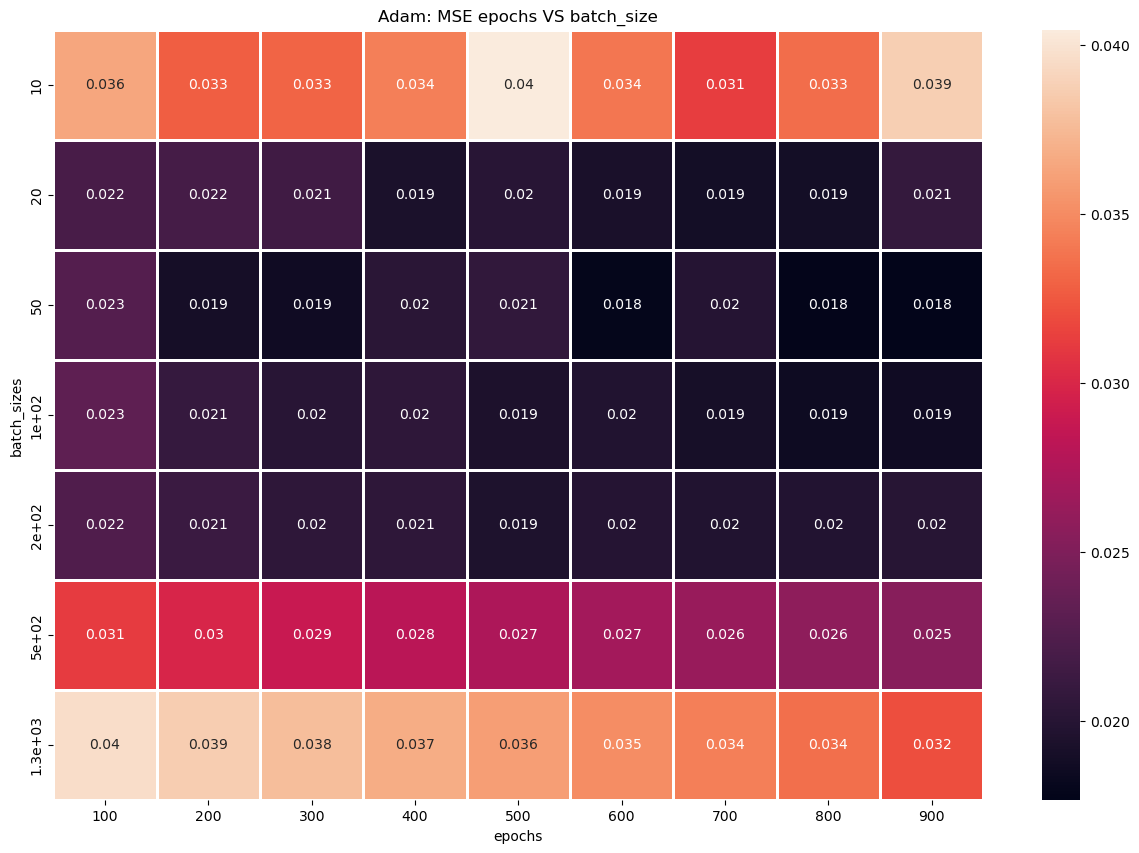

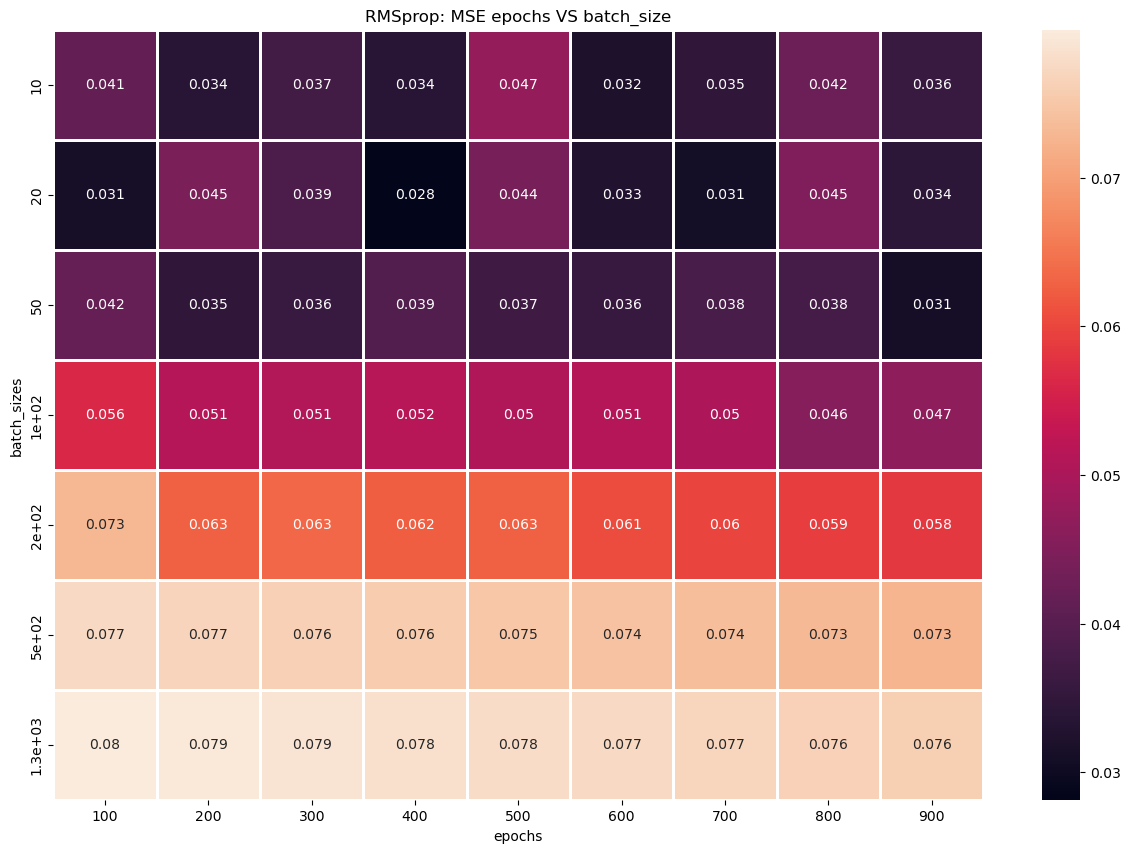

In [22]:
fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_const,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('Constant $\eta $: MSE epochs VS batch_size')

fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_mom,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('Mom: MSE epochs VS batch_size')

fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_adg,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('Adagrad: MSE epochs VS batch_size')

fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_adgmom,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('Adagrad with mom: MSE epochs VS batch_size')

fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_adam,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('Adam: MSE epochs VS batch_size')

fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_rms,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('RMSprop: MSE epochs VS batch_size')

$\eta=0.01$ way better for Adagrad, Adam and RMSprop

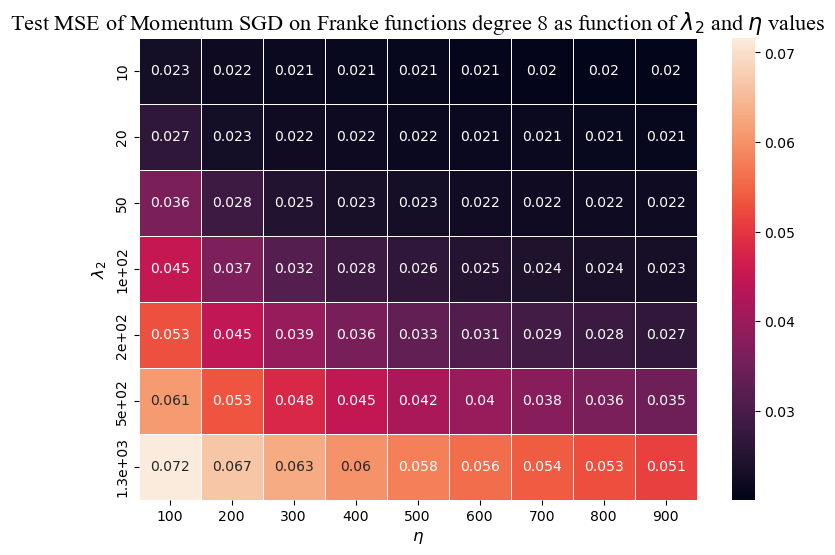

In [23]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df_const, annot=True, fmt=".2g", linewidths=.5, ax=ax)
ax.set_ylabel('$\lambda_2$', fontdict={'fontfamily': 'Times New Roman'}, fontsize=12)
ax.set_xlabel('$\eta$', fontdict={'fontfamily': 'Times New Roman'}, fontsize=12)
plt.title("Test MSE of Momentum SGD on Franke functions degree 8 as function of $\lambda_2$ and $\eta$ values",fontdict={'fontfamily': 'Times New Roman'}, fontsize=16)
plt.savefig("MSE_ETAS_LAMBDAS_momentum")
plt.show()